### This notebook evaluates a grid run of multiple models using pre-defined metrics 

In [162]:
import numpy as np
import pandas as pd
import os
import scipy.stats 
import h5py
import loss
from tensorflow.python.keras import backend as K
from modelzoo import *
import seaborn as sns
import matplotlib.pyplot as plt

In [139]:
def np_mse(a, b):
    return ((a - b)**2).mean(axis=0).mean(axis=0)

def scipy_pr(y_true, y_pred):
    _,_,T = y_true.shape
    res_pr = np.zeros(T)
    for t in range(T):
        pr = scipy.stats.pearsonr(y_true[:,:,t].flatten(), y_pred[:,:,t].flatten())[0]
        res_pr[t] = pr
    return res_pr

def np_poiss(y_true, y_pred):
    return np.nanmean(np.nanmean(y_pred - y_true * np.log(y_pred), axis=0), axis=0)

def loop_pois(y_true, y_pred):
    _,_,T = y_true.shape
    res_pr = np.zeros(T)
    for t in range(T):
        pr = np_poiss(y_true[:,:,t].flatten(), y_pred[:,:,t].flatten())
        res_pr[t] = np.nanmean(pr) 
#         print(pr)
#         break
    return res_pr

def get_metrics(y_true, y_pred):
    mse = np_mse(test_y, test_pred)
    pr = scipy_pr(test_y, test_pred)
    pois = np_poiss(test_y, test_pred)
    return ({'mse': mse,
            'pr': pr,
             'pois': pois})

In [140]:
grid_dir = 'datasets/ATAC_bin/grid4'
preds = [os.path.join(grid_dir, file) for file in os.listdir(grid_dir) if (file.endswith('.h5') and 'pred_' in file)]

In [ ]:
eval_metrics = {}
for pred in preds:
    dataset = h5py.File(pred, 'r')
    test_pred = dataset['test_pred'][:]
    test_y = dataset['test_y'][:]
    eval_metrics[pred] = get_metrics(test_y, test_pred)

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


In [184]:
all_metrics = []
for e, (k,v) in enumerate(eval_metrics.items()):
    if 'basenjipearsonr' not in k:
        metrics_per_exp = pd.DataFrame({'Pearson R basenji':[], 
                                    'input_size':[], 
                                    'bin_size':[],
                                    'model':[],
                                    'loss':[],
                                    'mse':[],
                                    'poisson':[] })
        metrics_per_exp['Pearson R basenji'] = v['pr']
        _,_,i,_,w,m,l = k.split('/')[-1].split('.h5')[0].split('_')
        metrics_per_exp['label'] = k.split('.h5')[0].split('pred_')[-1]
        metrics_per_exp['input_size'] = i
        metrics_per_exp['bin_size'] = w
        metrics_per_exp['model'] = m
        metrics_per_exp['loss'] = l
        metrics_per_exp['mse'] = v['mse']
        metrics_per_exp['poisson'] = v['pois']
        metrics_per_exp['id'] = e
        all_metrics.append(metrics_per_exp)

In [185]:
all_metrics = pd.concat(all_metrics)

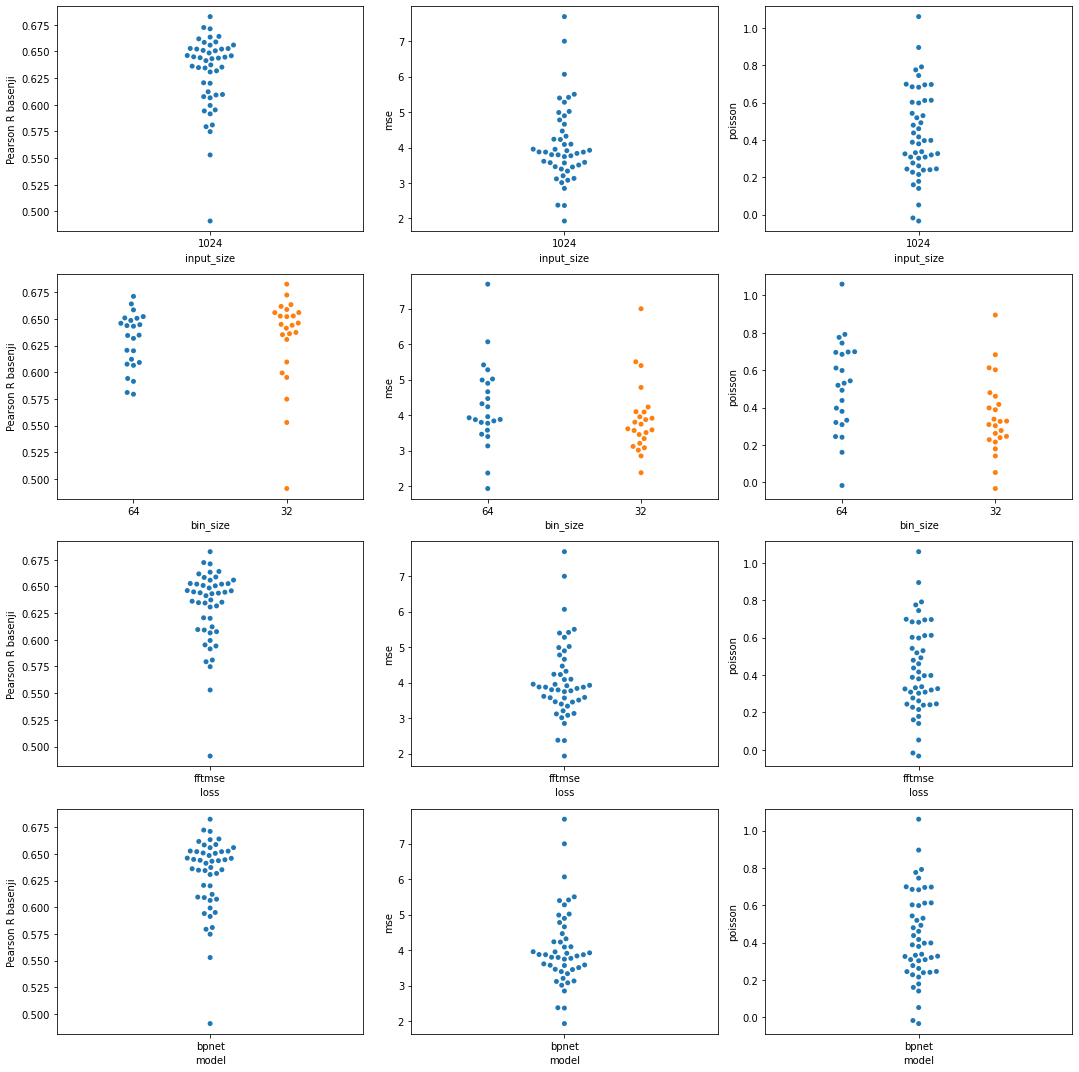

In [192]:
fig, axs = plt.subplots(4,3, figsize=[15,15])

for m, met in enumerate(['Pearson R basenji', 'mse', 'poisson']):

    _=sns.swarmplot(x='input_size', y=met, data=all_metrics, ax=axs[0,m])
    _=sns.swarmplot(x='bin_size', y=met, data=all_metrics, ax=axs[1,m])
    _=sns.swarmplot(x='loss', y=met, data=all_metrics, ax=axs[2,m])
    _=sns.swarmplot(x='model', y=met, data=all_metrics, ax=axs[3,m])
#     axs[2,m].set_xticklabels(axs[2,m].get_xticklabels(), rotation=90)
# axs[2].set_xticks()
plt.tight_layout()

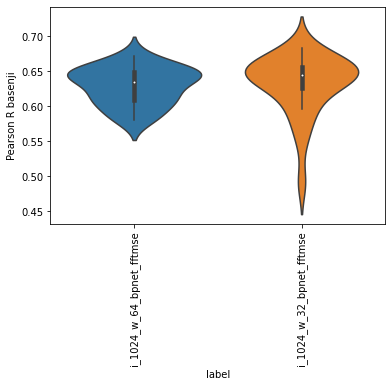

In [190]:
_=sns.violinplot(x='label', y='Pearson R basenji', data=all_metrics)
_=plt.xticks(rotation=90)

In [183]:
all_metrics.to_csv('grid4_eval_metrics.csv')